In [1]:
import tensorflow as tf
import numpy as np
from importlib.machinery import SourceFileLoader
tfFns = SourceFileLoader("tfFns.py", "/home/msmith/misc/tfFunctions/tfFns.py").load_module()
from numpy import prod
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
from tqdm import tnrange, tqdm_notebook
from time import sleep
import math

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

/usr/local/lib/python3.4/dist-packages/matplotlib-1.5.1+1797.g6bed1be-py3.4-linux-x86_64.egg/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [25]:
def hstackBatch(batch):
    batch = batch.squeeze()
    batchSize = batch.shape[0]
    x = batch[0]
    for i in range(1,batchSize):
        x = np.hstack((x,batch[i]))
    return x

def getImgsFrmClass(Class,trOrTest):
    assert trOrTest in ("train","test"), "Please specify 'train' or 'test'"
    if trOrTest == "train":
        data = mnist.train
    elif trOrTest == "test":
        data = mnist.test
    idx = data.labels.argmax(1) == Class
    imgs = data.images[idx]
    return imgs

def batchGen(Class,batchSize,trOrTest):
       
    imgs = getImgsFrmClass(Class,trOrTest)
    n,shape = imgs.shape
    idx = 0
    while True:
        newBatch = np.empty((batchSize,shape))
        for i in range(batchSize):
            newBatch[i] = imgs[idx]
            idx += 1
            if idx == n:
                idx = 0
        yield newBatch

In [278]:
batchSize = 20
x = tf.placeholder(tf.float32, shape=[batchSize, 784])

#Encoding layers
xReshape = tf.reshape(x, [batchSize,28,28,1])

feats = 8
W_conv1 = tfFns.weight_variable([3, 3, 1, feats])
b_conv1 = tfFns.bias_variable([feats])

W_conv2 = tfFns.weight_variable([3, 3, feats, feats])
b_conv2 = tfFns.bias_variable([feats])

W_conv3 = tfFns.weight_variable([3, 3, feats, feats])
b_conv3 = tfFns.bias_variable([feats])

W_conv4 = tfFns.weight_variable([3, 3, feats, feats])
b_conv4 = tfFns.bias_variable([feats])

#Decoding layers
outputShape5 = [batchSize,8,8,feats]
W_deconv1 = tfFns.weight_variable([3, 3, feats, feats])
b_deconv1 = tfFns.bias_variable([feats])

outputShape6 = [batchSize,16,16,1]
W_deconv2 = tfFns.weight_variable([3, 3, 1, feats])
b_deconv2 = tfFns.bias_variable([1])

'''
outputShape7 = [batchSize,28,28,1]
W_deconv3 = tfFns.weight_variable([3, 3, 1, feats])
b_deconv3 = tfFns.bias_variable([1])
'''

h_conv1 = tf.nn.relu(tfFns.conv2d(xReshape, W_conv1) + b_conv1)
h_pool1 = tfFns.max_pool_2x2(h_conv1)

h_conv2 = tf.nn.relu(tfFns.conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = tfFns.max_pool_2x2(h_conv2)

h_conv3 = tf.nn.relu(tfFns.conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = tfFns.max_pool_2x2(h_conv3)

h_conv4PreRelu = tfFns.conv2d(h_pool3, W_conv4) + b_conv4
h_conv4 = tf.nn.relu(h_conv4PreRelu)

h_deconv1 = tf.nn.relu(tfFns.deconv2d(h_conv4, W_deconv1, output_shape=outputShape5) + b_deconv1)

yPred = tf.nn.relu(tfFns.deconv2d(h_deconv1, W_deconv2, output_shape=outputShape6) + b_deconv2)

'''
h_deconv2 = tf.nn.relu(tfFns.deconv2d(h_deconv1,W_deconv2,output_shape=outputShape6) + b_deconv2)

yPred = tf.nn.sigmoid(tfFns.deconv2d(h_deconv2,W_deconv3,output_shape=outputShape7) + b_deconv3)
'''
yPredShape = yPred.get_shape().as_list()
xResize = tf.image.resize_bilinear(xReshape,(yPredShape[1],yPredShape[2]))
mse = tf.reduce_sum(tf.square(yPred - xResize))
train_step = tf.train.AdamOptimizer(0.01).minimize(mse)

for l in [x,xResize,h_conv1,h_pool1,h_conv2,h_pool2,h_conv3, h_conv4, yPred, xResize, mse]:
    print("shape, elements = %s, %s." % (l.get_shape(),prod(l.get_shape().as_list()[1:])))

shape, elements = (20, 784), 784.
shape, elements = (20, 16, 16, 1), 256.
shape, elements = (20, 28, 28, 8), 6272.
shape, elements = (20, 14, 14, 8), 1568.
shape, elements = (20, 14, 14, 8), 1568.
shape, elements = (20, 7, 7, 8), 392.
shape, elements = (20, 7, 7, 8), 392.
shape, elements = (20, 4, 4, 8), 128.
shape, elements = (20, 16, 16, 1), 256.
shape, elements = (20, 16, 16, 1), 256.
shape, elements = (), 1.0.


In [280]:
iterations = int(3e3)
ma = math.floor(iterations/2)
mseAv = []
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.initialize_all_variables())
    for i in tqdm_notebook(range(iterations),desc='1st loop'):
        batchX, batchY = mnist.train.next_batch(batchSize)
        _, mse_, yPred_, xResize_, xReshape_ = sess.run([train_step,mse,yPred,xResize,xReshape],feed_dict={x: batchX})
        mseAv.append(mse_)
        if i % ma == 0 and i > 0 or i == iterations:
            print("*"*100)
            print("Mean loss after %d iterations of batch size %d = %f " % (i,batchSize,np.array(mseAv).mean()))
    saver.save(sess, "model.chk")

****************************************************************************************************
Mean loss after 1500 iterations of batch size 20 = 98.731430 



Number/Class = 0


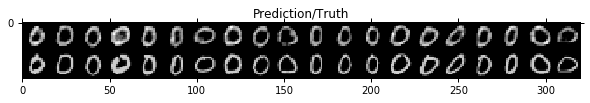

Number/Class = 1


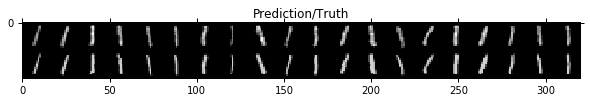

Number/Class = 2


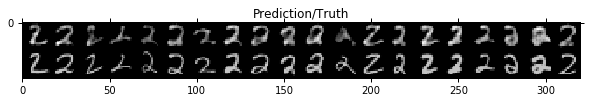

Number/Class = 3


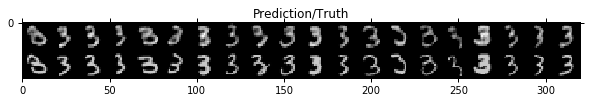

Number/Class = 4


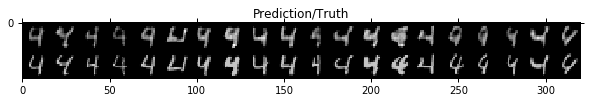

Number/Class = 5


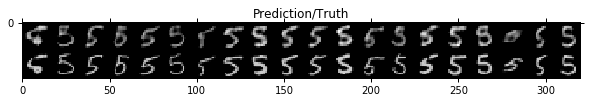

Number/Class = 6


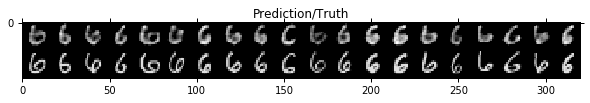

Number/Class = 7


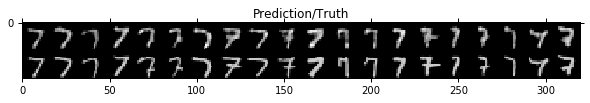

Number/Class = 8


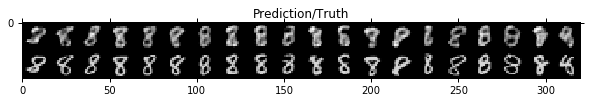

Number/Class = 9


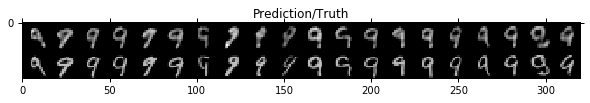

In [286]:
with tf.Session() as sess:        
    saver.restore(sess, "model.chk")
    encodings0 = []
    encodings1 = []
    encodings2 = []
    encodings3 = []
    for number in range(10):
        numGen = batchGen(number,batchSize,"test")
        mse_, yPred_, xResize_, xReshape_, encoding0_, encoding1_, encoding2_, encoding3_ = sess.run([mse,yPred,xResize,xReshape,h_conv2, h_conv3,h_conv4,h_deconv1],feed_dict={x: next(numGen)})
        encodings0.append(encoding0_)
        encodings1.append(encoding1_)
        encodings2.append(encoding2_)
        encodings3.append(encoding3_)

        print("Number/Class = %d" % number)
        plt.title("Prediction/Truth")
        plt.imshow(np.vstack((hstackBatch(yPred_),hstackBatch(xResize_))),cmap=cm.gray)
        plt.show()

Feature map = 0 and Class = 0 


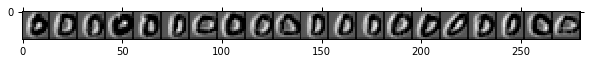

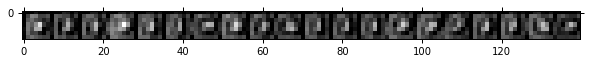

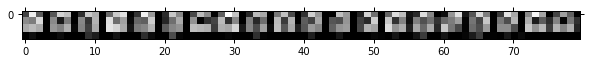

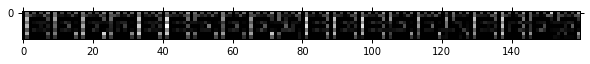

Feature map = 0 and Class = 1 


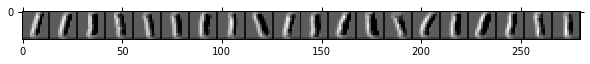

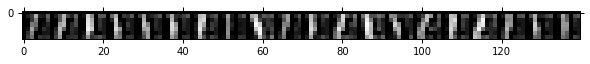

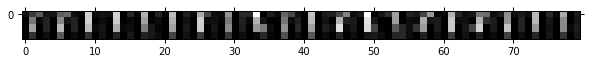

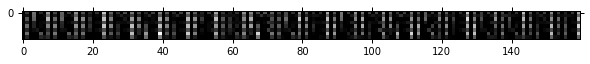

Feature map = 0 and Class = 2 


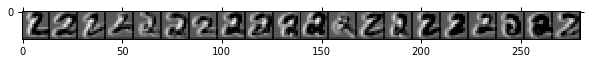

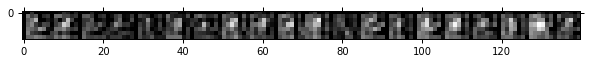

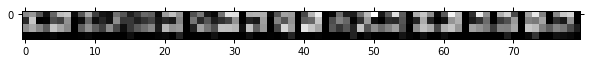

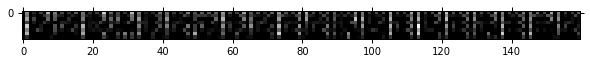

Feature map = 0 and Class = 3 


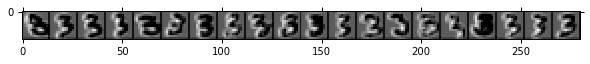

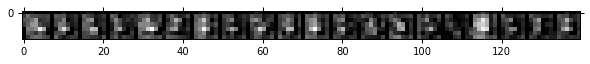

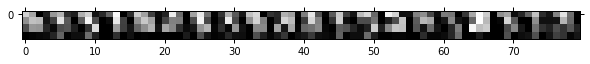

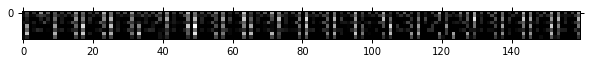

Feature map = 0 and Class = 4 


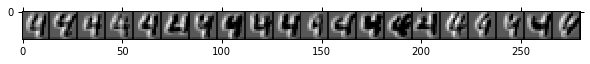

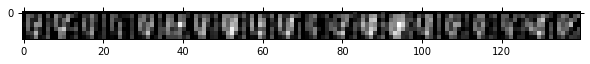

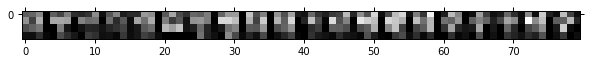

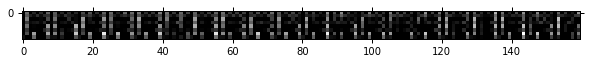

Feature map = 0 and Class = 5 


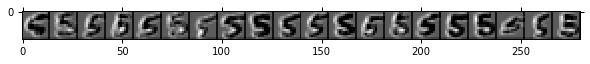

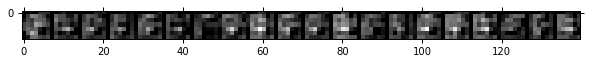

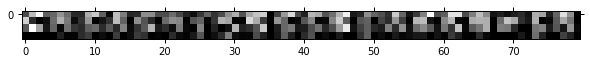

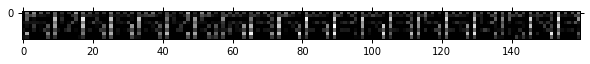

Feature map = 0 and Class = 6 


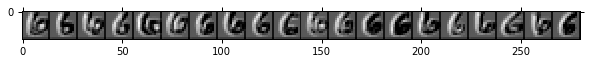

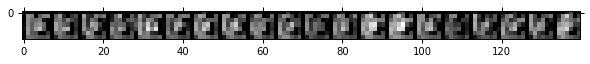

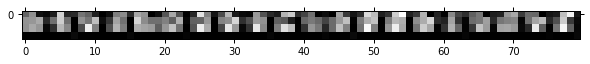

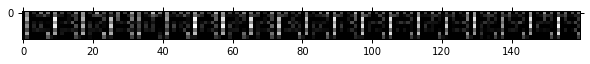

Feature map = 0 and Class = 7 


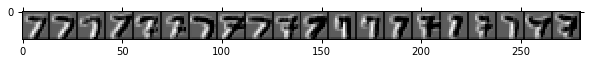

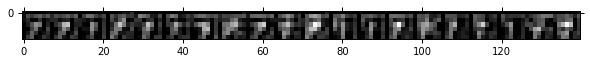

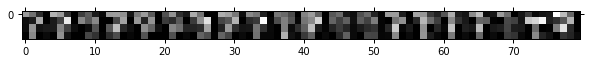

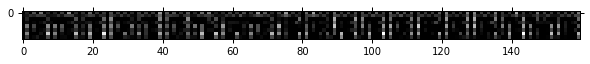

Feature map = 0 and Class = 8 


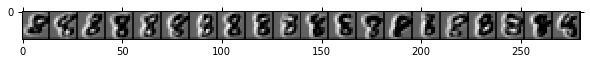

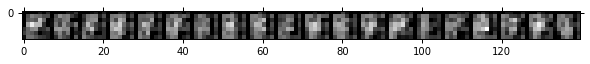

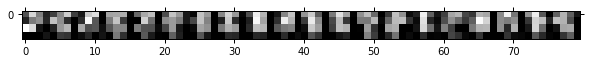

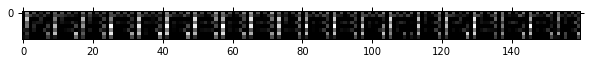

Feature map = 0 and Class = 9 


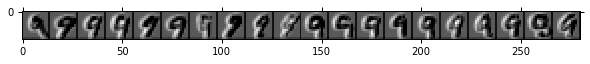

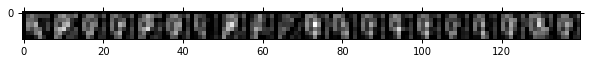

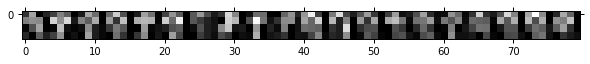

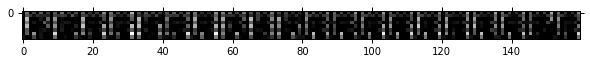

Feature map = 1 and Class = 0 


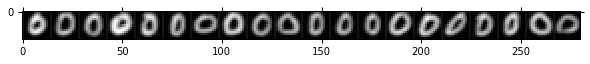

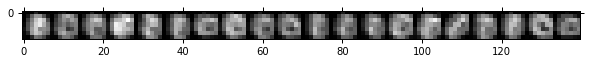

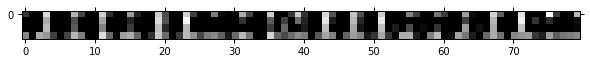

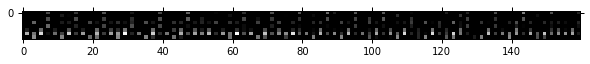

Feature map = 1 and Class = 1 


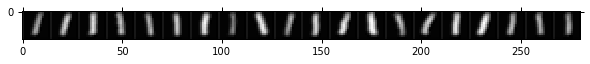

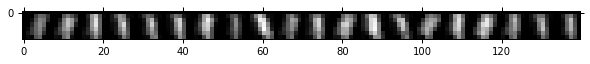

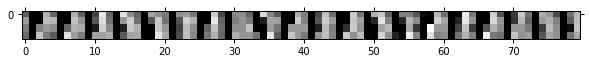

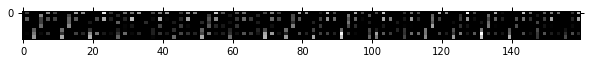

Feature map = 1 and Class = 2 


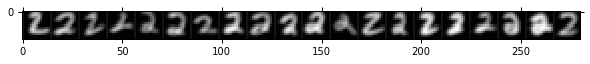

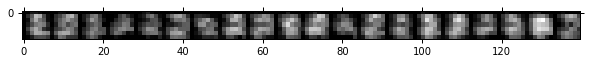

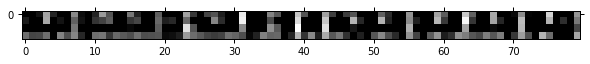

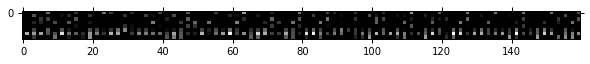

Feature map = 1 and Class = 3 


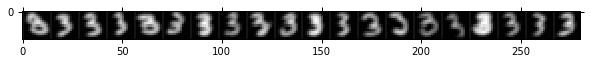

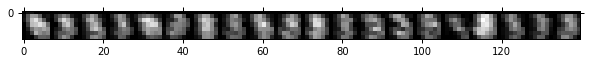

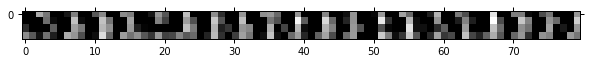

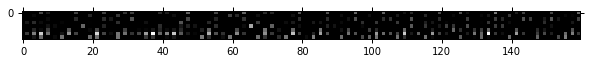

Feature map = 1 and Class = 4 


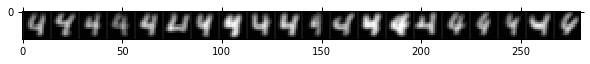

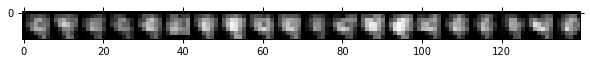

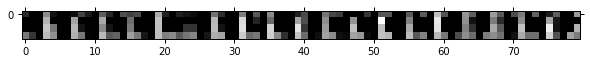

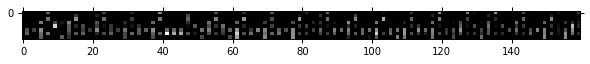

Feature map = 1 and Class = 5 


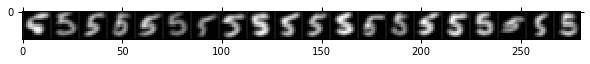

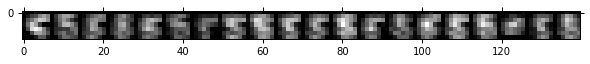

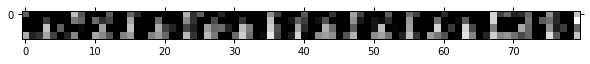

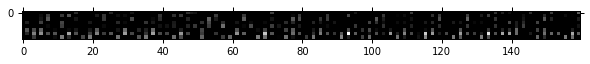

Feature map = 1 and Class = 6 


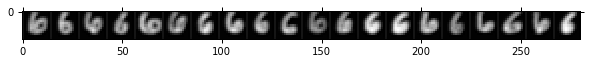

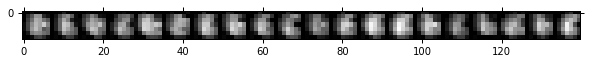

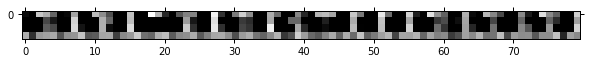

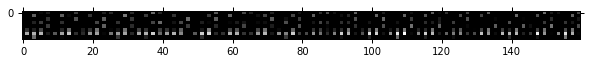

Feature map = 1 and Class = 7 


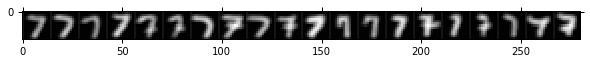

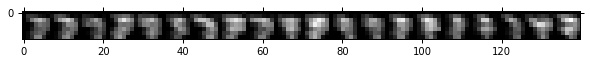

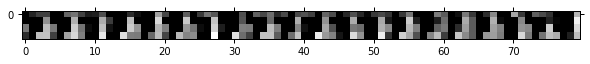

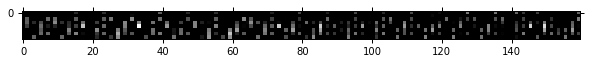

Feature map = 1 and Class = 8 


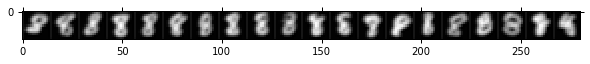

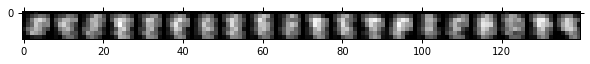

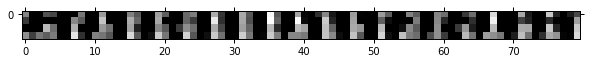

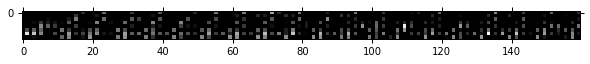

Feature map = 1 and Class = 9 


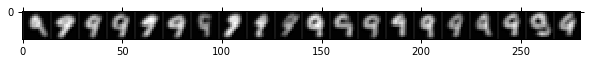

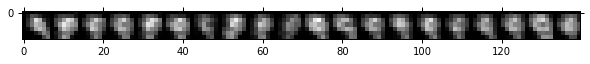

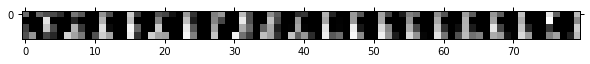

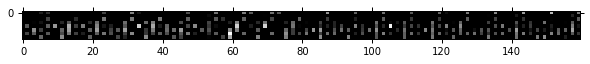

Feature map = 2 and Class = 0 


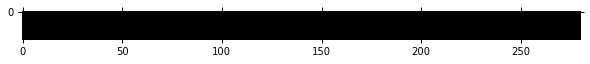

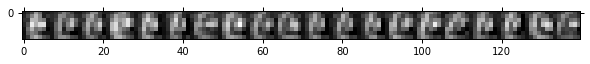

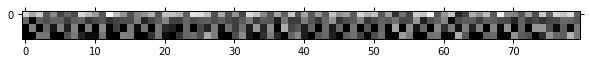

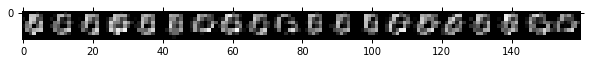

Feature map = 2 and Class = 1 


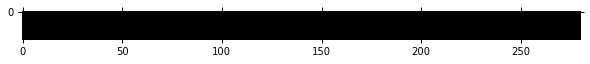

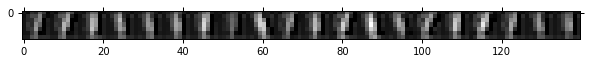

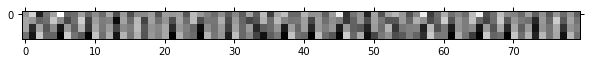

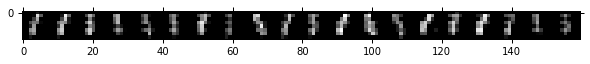

Feature map = 2 and Class = 2 


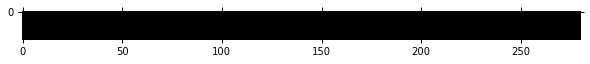

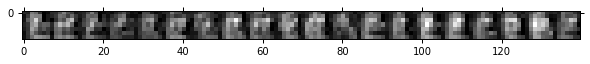

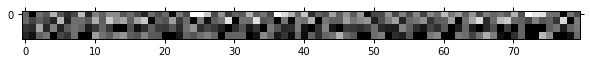

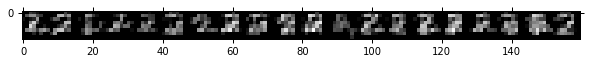

Feature map = 2 and Class = 3 


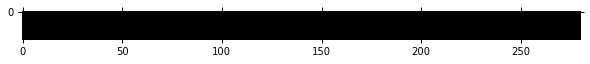

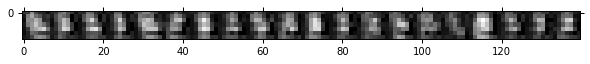

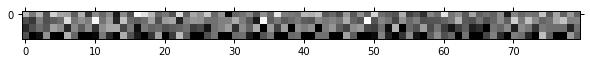

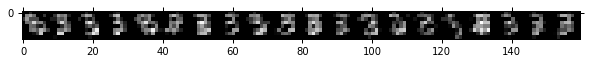

Feature map = 2 and Class = 4 


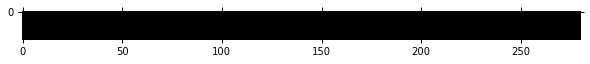

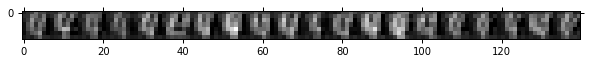

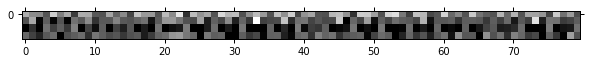

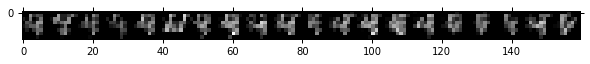

Feature map = 2 and Class = 5 


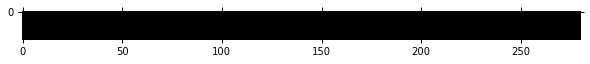

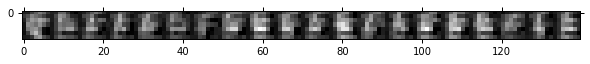

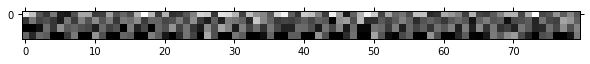

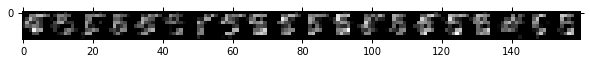

Feature map = 2 and Class = 6 


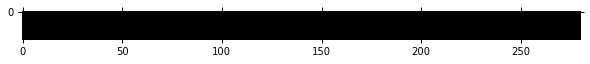

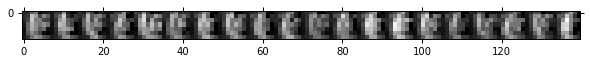

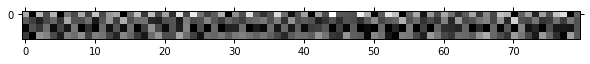

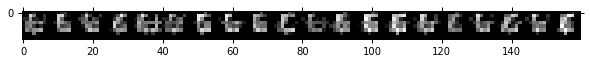

Feature map = 2 and Class = 7 


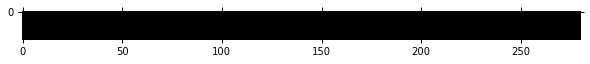

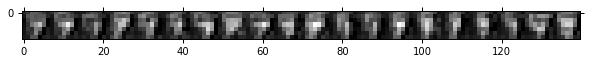

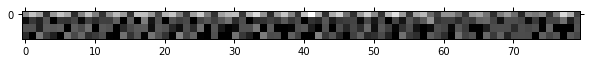

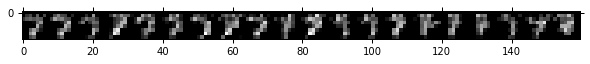

Feature map = 2 and Class = 8 


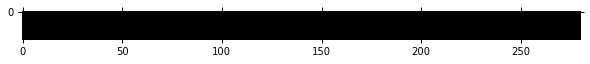

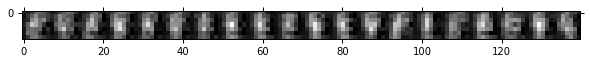

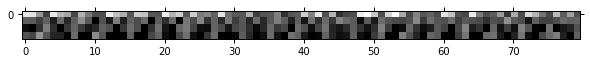

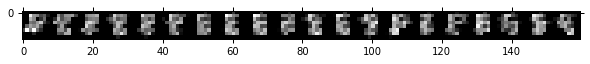

Feature map = 2 and Class = 9 


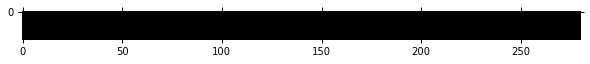

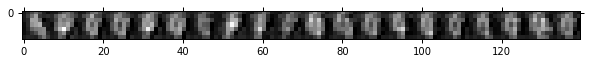

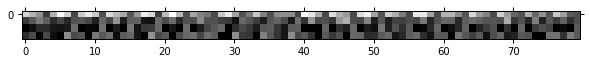

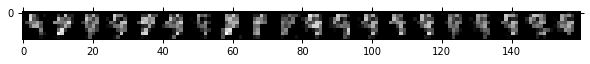

Feature map = 3 and Class = 0 


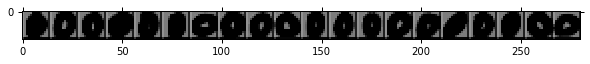

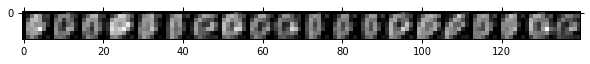

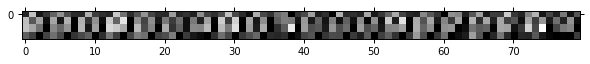

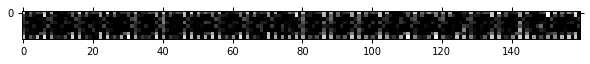

Feature map = 3 and Class = 1 


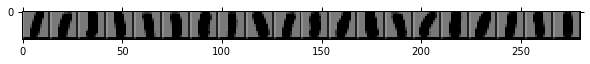

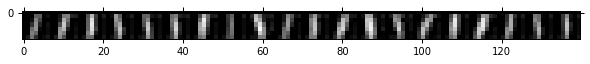

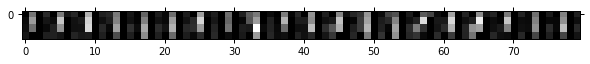

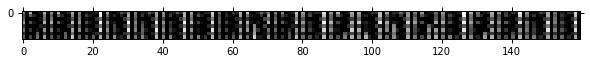

Feature map = 3 and Class = 2 


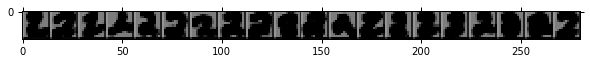

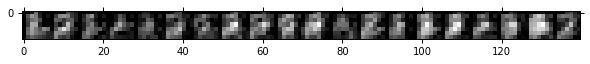

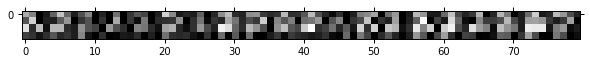

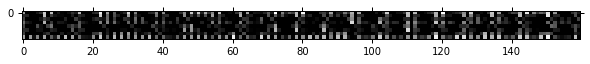

Feature map = 3 and Class = 3 


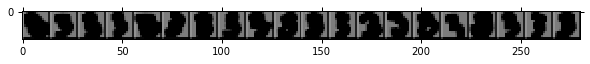

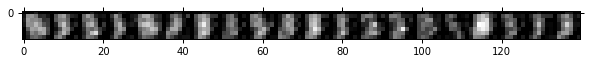

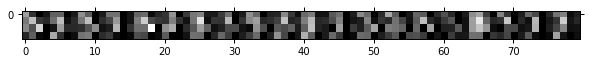

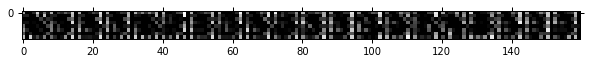

Feature map = 3 and Class = 4 


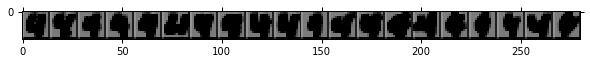

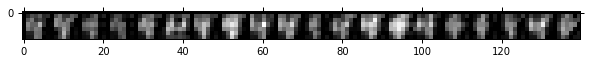

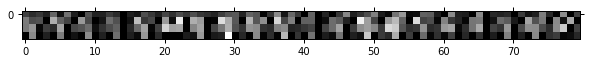

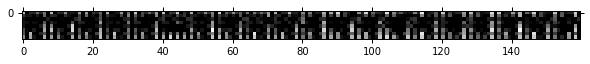

Feature map = 3 and Class = 5 


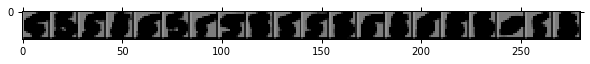

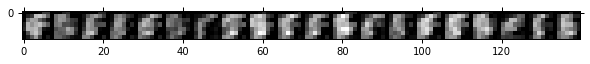

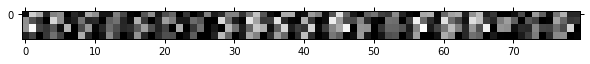

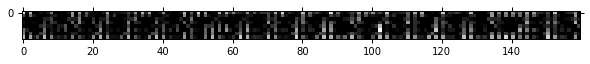

Feature map = 3 and Class = 6 


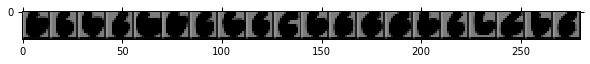

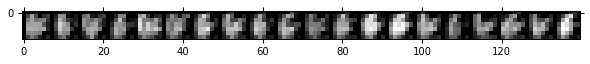

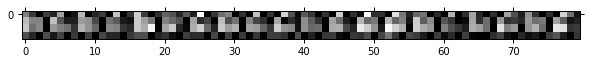

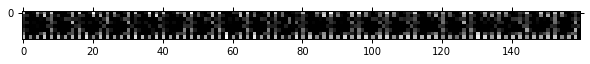

Feature map = 3 and Class = 7 


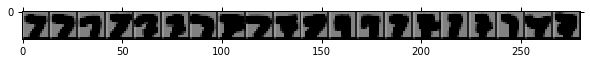

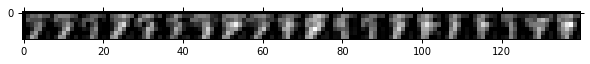

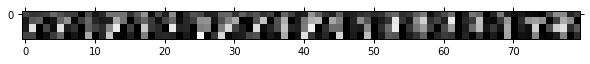

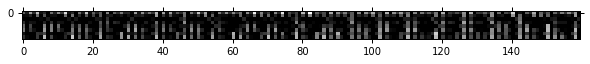

Feature map = 3 and Class = 8 


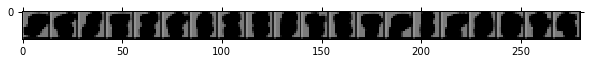

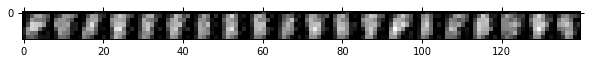

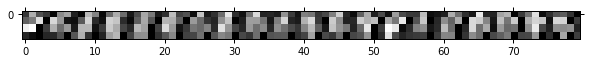

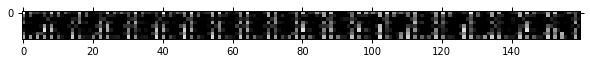

Feature map = 3 and Class = 9 


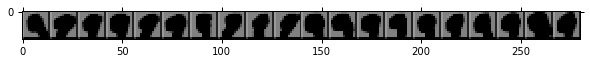

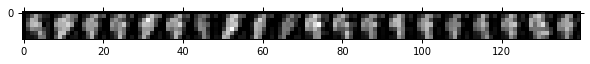

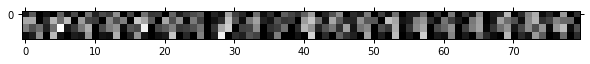

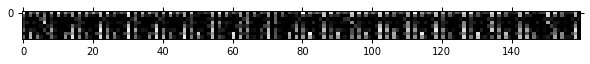

Feature map = 4 and Class = 0 


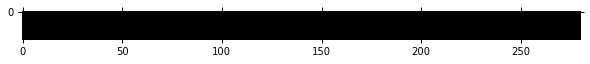

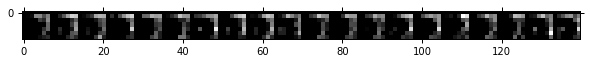

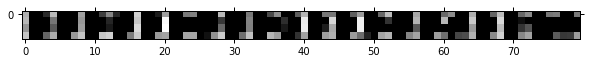

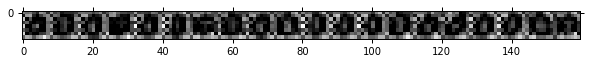

Feature map = 4 and Class = 1 


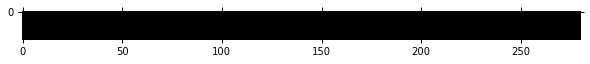

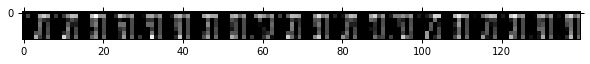

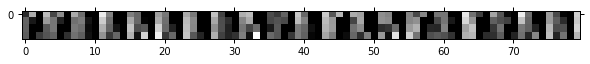

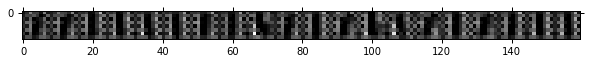

Feature map = 4 and Class = 2 


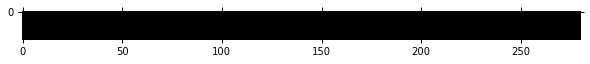

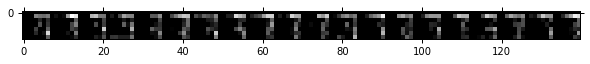

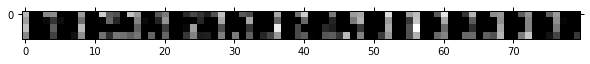

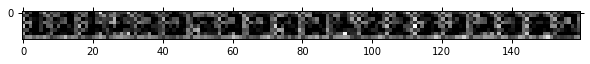

Feature map = 4 and Class = 3 


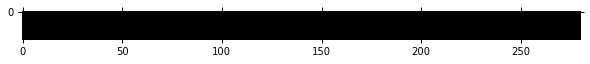

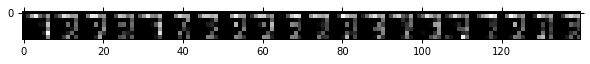

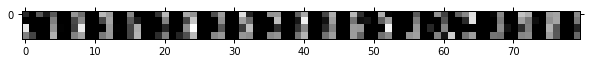

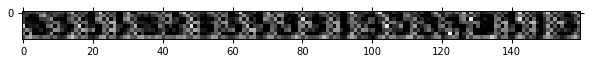

Feature map = 4 and Class = 4 


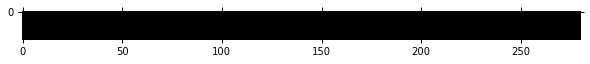

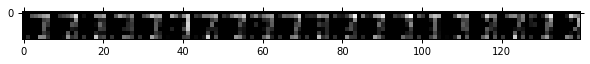

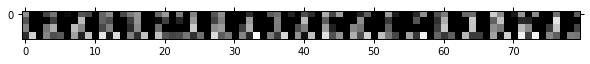

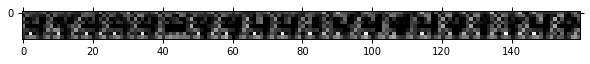

Feature map = 4 and Class = 5 


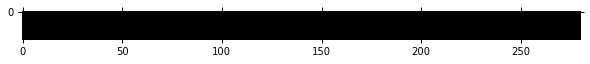

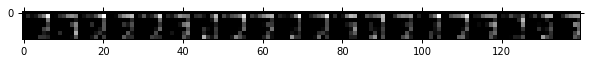

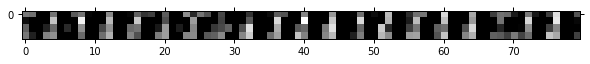

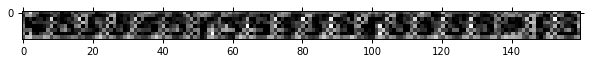

Feature map = 4 and Class = 6 


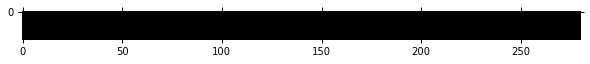

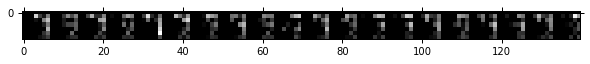

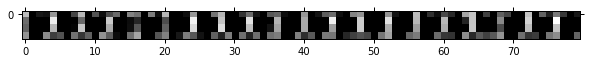

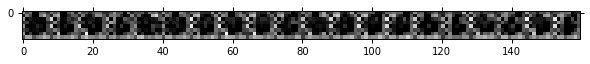

Feature map = 4 and Class = 7 


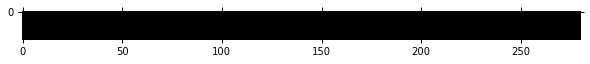

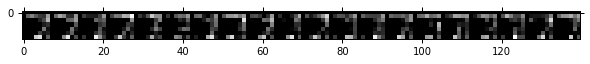

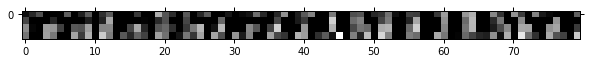

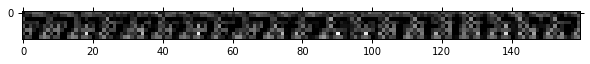

Feature map = 4 and Class = 8 


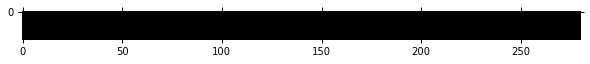

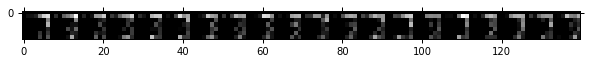

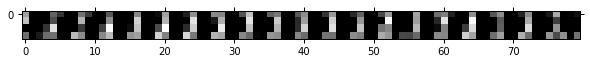

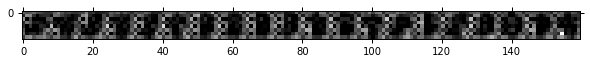

Feature map = 4 and Class = 9 


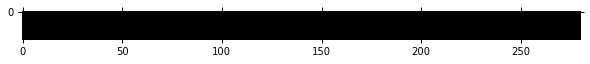

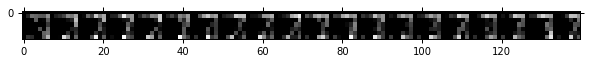

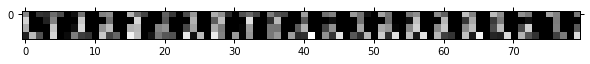

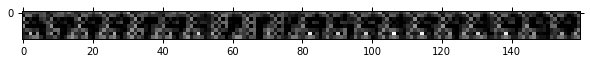

Feature map = 5 and Class = 0 


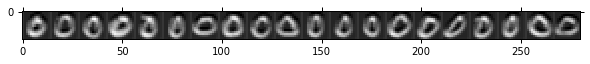

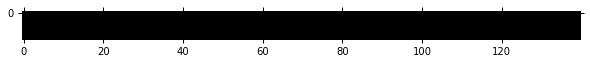

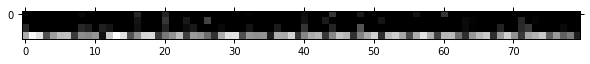

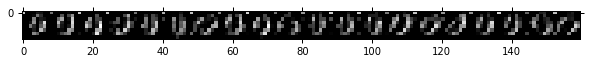

Feature map = 5 and Class = 1 


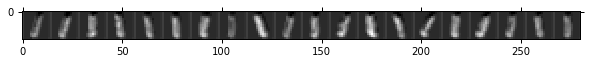

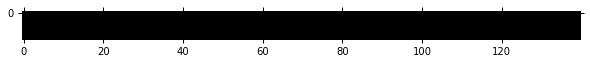

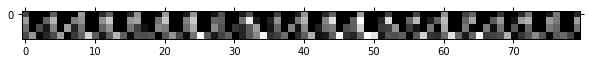

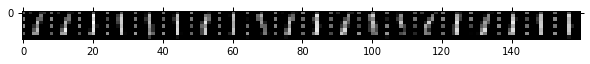

Feature map = 5 and Class = 2 


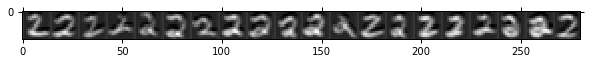

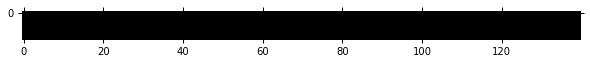

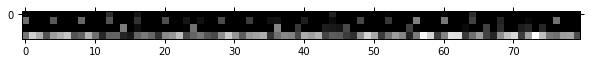

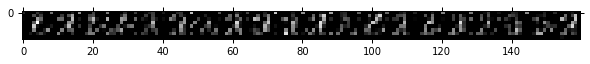

Feature map = 5 and Class = 3 


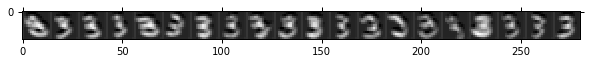

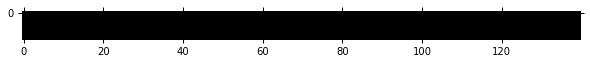

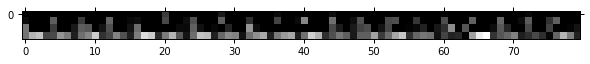

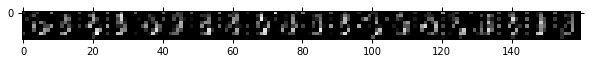

Feature map = 5 and Class = 4 


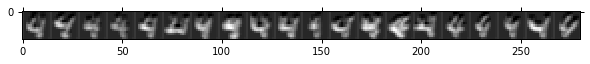

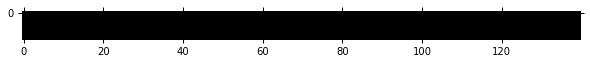

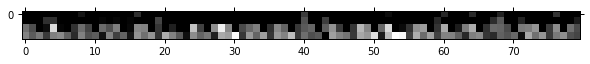

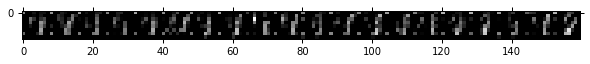

Feature map = 5 and Class = 5 


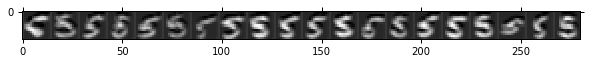

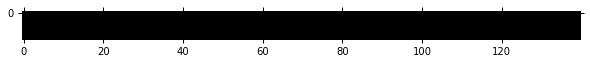

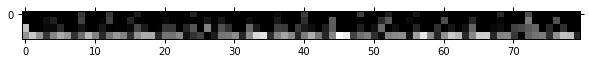

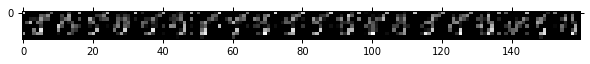

Feature map = 5 and Class = 6 


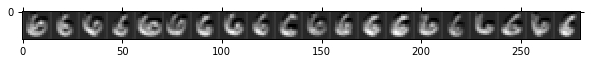

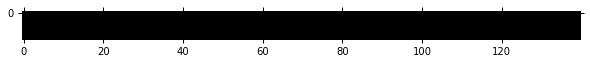

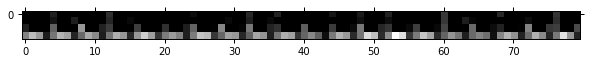

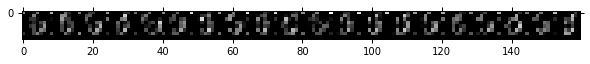

Feature map = 5 and Class = 7 


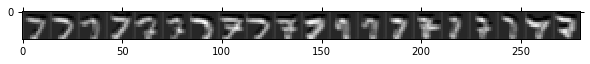

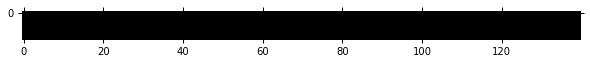

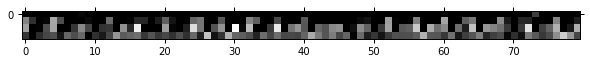

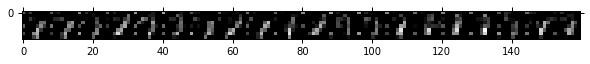

Feature map = 5 and Class = 8 


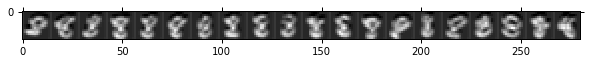

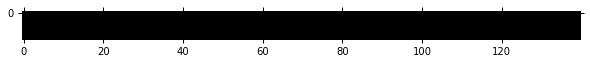

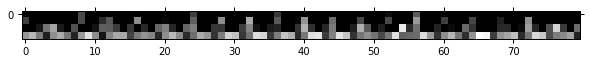

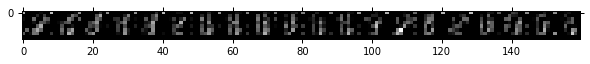

Feature map = 5 and Class = 9 


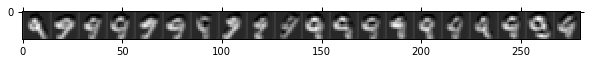

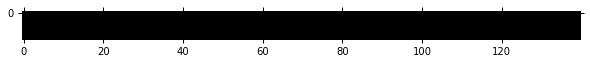

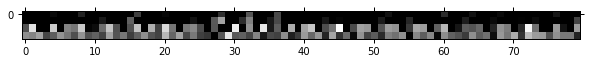

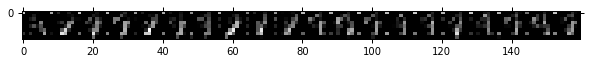

Feature map = 6 and Class = 0 


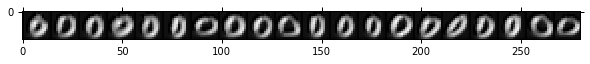

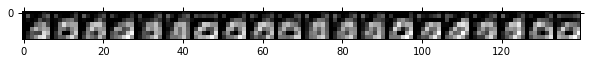

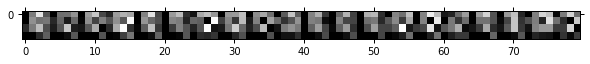

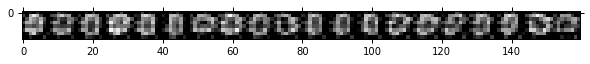

Feature map = 6 and Class = 1 


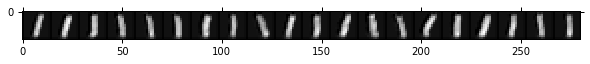

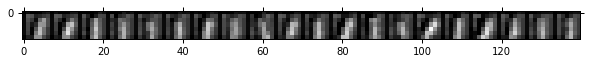

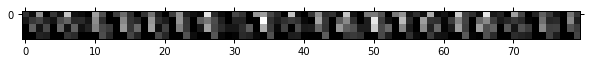

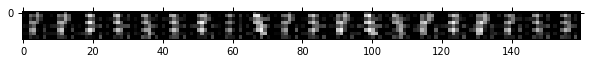

Feature map = 6 and Class = 2 


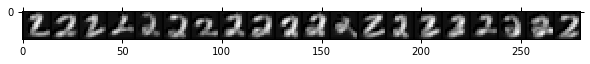

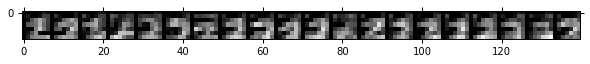

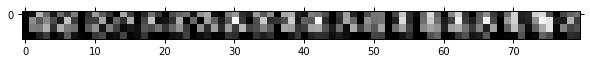

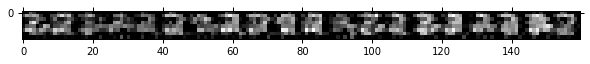

Feature map = 6 and Class = 3 


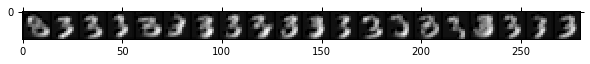

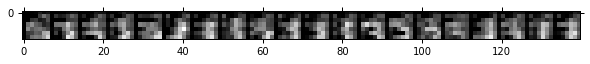

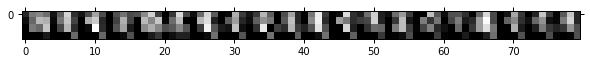

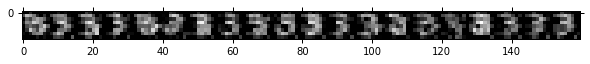

Feature map = 6 and Class = 4 


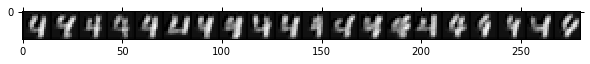

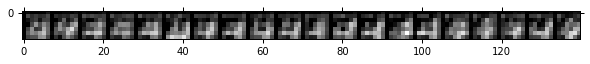

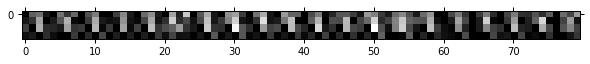

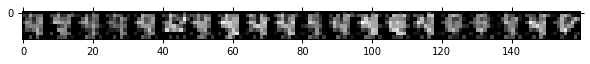

Feature map = 6 and Class = 5 


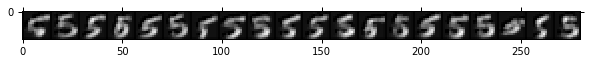

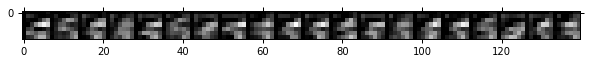

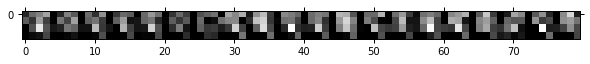

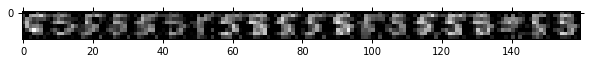

Feature map = 6 and Class = 6 


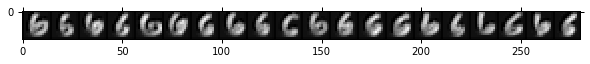

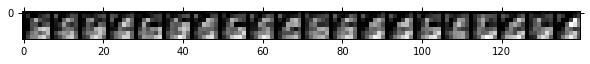

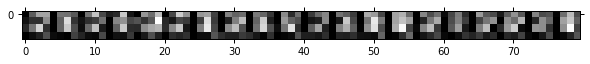

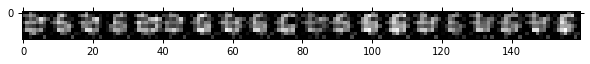

Feature map = 6 and Class = 7 


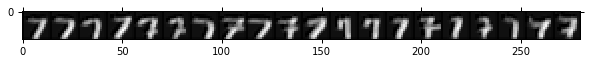

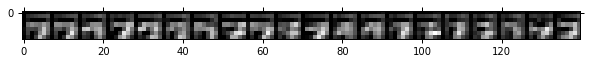

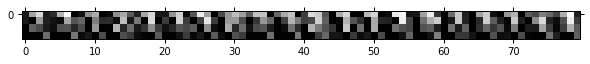

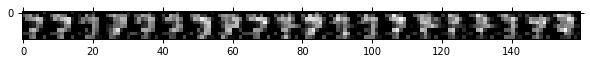

Feature map = 6 and Class = 8 


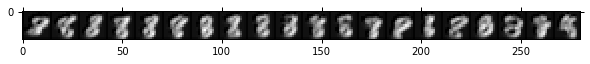

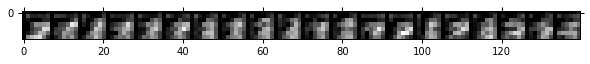

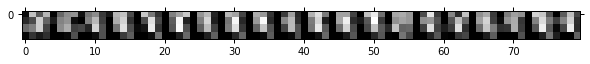

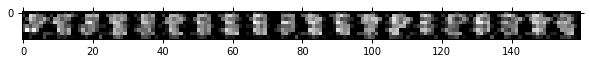

Feature map = 6 and Class = 9 


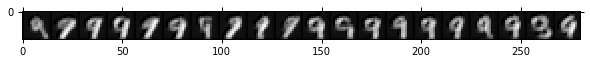

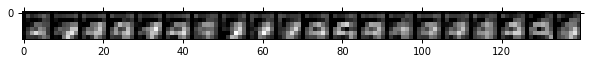

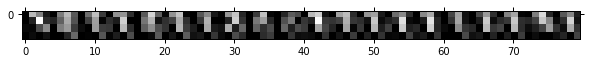

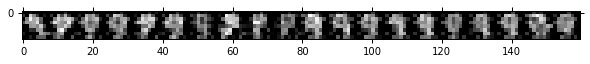

Feature map = 7 and Class = 0 


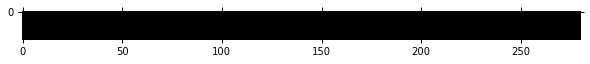

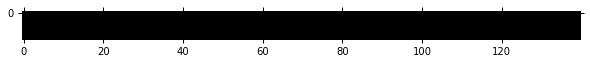

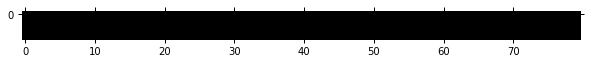

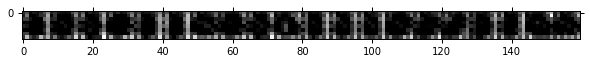

Feature map = 7 and Class = 1 


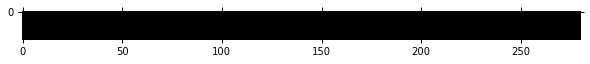

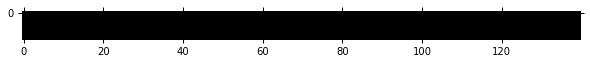

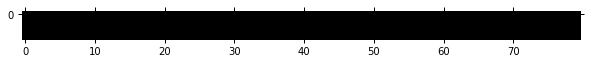

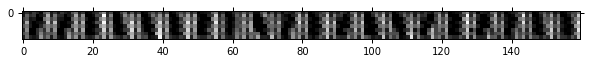

Feature map = 7 and Class = 2 


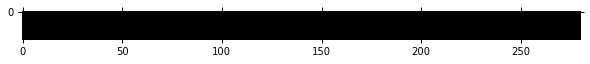

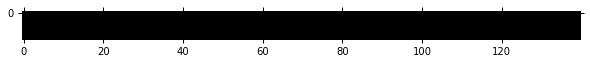

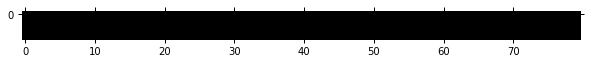

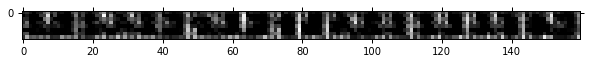

Feature map = 7 and Class = 3 


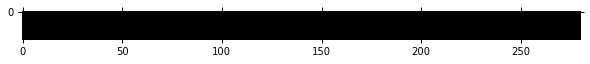

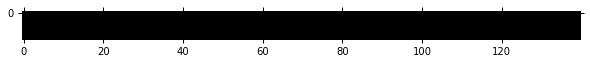

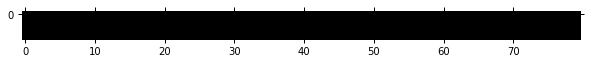

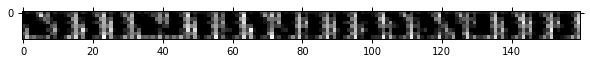

Feature map = 7 and Class = 4 


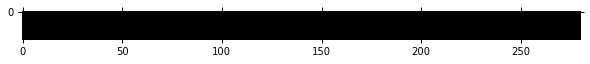

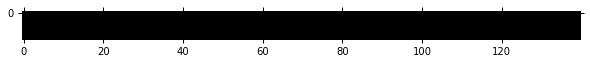

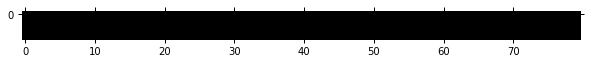

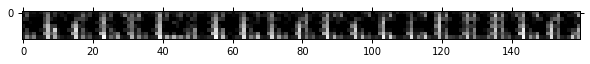

Feature map = 7 and Class = 5 


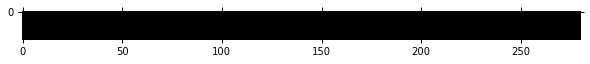

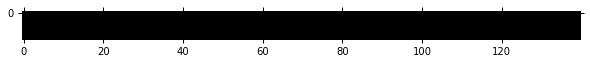

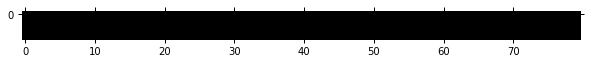

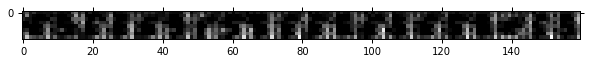

Feature map = 7 and Class = 6 


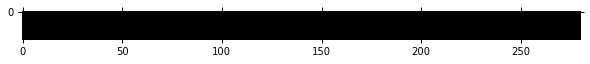

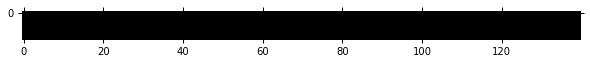

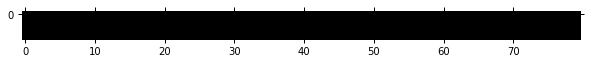

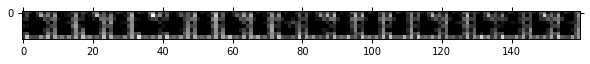

Feature map = 7 and Class = 7 


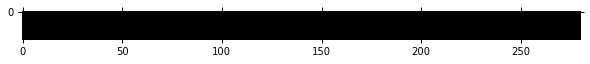

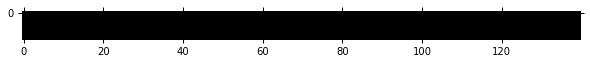

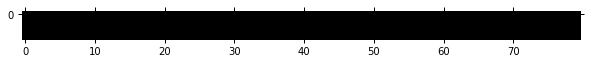

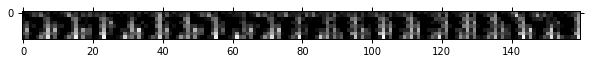

Feature map = 7 and Class = 8 


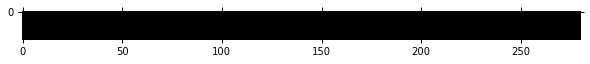

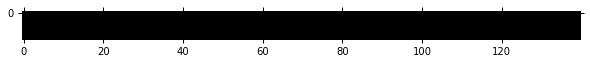

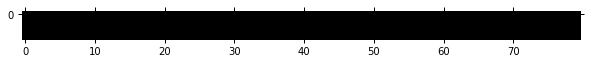

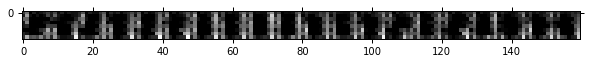

Feature map = 7 and Class = 9 


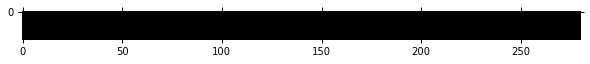

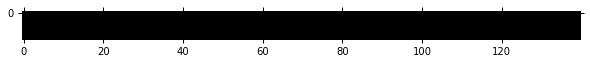

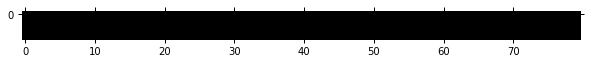

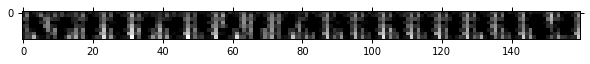

In [287]:
for featureMap in range(8):

    for number in range(10):
        
        
            print("Feature map = %d and Class = %d " %(featureMap,number))
            
            plt.imshow(hstackBatch(encodings0[number][:,:,:,featureMap]),cmap=cm.gray)
            plt.show()
            
            plt.imshow(hstackBatch(encodings1[number][:,:,:,featureMap]),cmap=cm.gray)
            plt.show()
            
            plt.imshow(hstackBatch(encodings2[number][:,:,:,featureMap]),cmap=cm.gray)
            plt.show()
            
            plt.imshow(hstackBatch(encodings3[number][:,:,:,featureMap]),cmap=cm.gray)
            plt.show()
            
            